# Analysis of DataSift dataset: 2M geolocations (unfiltered)

In [1]:
import pandas as pd
import numpy as np
from datetime import date,timedelta
from tqdm import tqdm
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
from scipy.spatial import cKDTree

def time_2_date(time_array):
    fechas=[];days=[];hours=[];minutes=[];seconds=[];years=[];months=[]
    for times in tqdm(time_array):
        try:
            tab_date=times.split('-')
            fecha=(date(int(tab_date[0]),int(tab_date[1]),int(tab_date[2][:2]))).weekday()
            hms=(times.split('T')[1])
            inter=hms.split(':')
            hour=inter[0];minute=inter[1];sec=inter[2][:2]
            year=tab_date[0]
            month=tab_date[1]
            day=tab_date[2][:2]
            years.append(year)
            days.append(day)
            fechas.append(fecha)
            hours.append(int(hour));minutes.append(int(minute));seconds.append(int(sec[:1]))
            months.append(month)
        except:
            print(times)
    return days,fechas,hours,minutes,seconds,years,months

work_hours=range(8,20)
home_hours=list(set(range(24))-set(work_hours))
work_days=range(5)
home_days=list(set(range(7))-set(work_days))

dgeo=pd.read_csv(header=None,sep="\t",filepath_or_buffer="y
                )
dgeo.columns=["usr","time","lat","lon"]
fechas,days,hours,minutes,seconds,years,months=time_2_date(dgeo.time)
dgeo['day']=days;dgeo['hour']=hours;dgeo['min']=minutes;dgeo['sec']=seconds;dgeo['year']=years;dgeo['month']=months;dgeo['fecha']=fechas
dgeo=dgeo.drop(labels="time",axis=1)

france=Polygon([[-4.9658203125,42.3585439175],[8.4375,42.3585439175],[8.4375,51.2344073516],[-4.9658203125,51.2344073516],[-4.9658203125,42.3585439175]])
locs=[Point((lon,lat)) for lon,lat in zip(dgeo.lon,dgeo.lat)]
 
dgeo_france=dgeo[[france.contains(geo_pt) for geo_pt in locs]]
dgeo_work=dgeo_france[dgeo_france.day.isin(work_days) & dgeo_france.hour.isin(work_hours)]#.drop(["day","hour"],axis=1)
dgeo_home=dgeo_france[dgeo_france.day.isin(home_days) | dgeo_france.hour.isin(home_hours)]#.drop(["day","hour"],axis=1fecha


100%|██████████| 2802577/2802577 [00:45<00:00, 61831.65it/s]


In [2]:
from collections import Counter
Counter((x[0],x[1])for x in (dgeo_france[["lat","lon"]].values)).most_common(3)

[((48.858833750000002, 2.3470029500000003), 111549),
 ((45.757821849999999, 4.8350989000000002), 16614),
 ((48.858853005923997, 2.3470054215047003), 13479)]

In [3]:
Counter((x[0],x[1])for x in (dgeo_home[["lat","lon"]].values)).most_common(1)

[((48.858833750000002, 2.3470029500000003), 61174)]

In [4]:
import seaborn as sns
sns.plt.figure(figsize=(30,30))
sns.plt.scatter(dgeo_france.lon,dgeo_france.lat,s=2)
sns.plt.show()

In [5]:
dic_user_home_datasift={}
for it,line in tqdm(dgeo_home.iterrows()):
    dic_user_home_datasift.setdefault(line.usr,[]).append([line.lat,line.lon,line.day,line.hour,
                                                           line['min'],line.sec,line.year,line.month,line.fecha])

1432136it [18:22, 1298.94it/s]


In [6]:
dic_usr_ds_info={k:pd.DataFrame(v,columns=["lat","lon","day","hour","minu","sec","year","month","fecha"]
               ) for k,v in tqdm(dic_user_home_datasift.items())}

100%|██████████| 90498/90498 [05:35<00:00, 269.94it/s]


In [7]:
datasift_relevant={k:v for k,v in dic_usr_ds_info.items()if (v.shape[0]>=1 and v.shape[0]<=200)}

In [8]:
from collections import Counter
from geopy.distance import vincenty
from datetime import datetime
import time
import numpy as np
from pyproj import Proj, transform
from scipy.spatial import cKDTree
from scipy import sparse
import sqlite3 as lite

from tqdm import tqdm
import sys
import os
path = "/datastore/complexnet/twitter/data/users.db"
con = lite.connect(path)
import warnings
warnings.filterwarnings("ignore")

#http://epsg.io/27700-5339 (accuracy: 1.0m)
uk = '+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 \
+x_0=400000 +y_0=-100000 +ellps=airy \
+towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs'
 

def proj_arr(points,proj_to):
    """Project geographic co-ordinates to get cartesian x,y. Transform(origin|destination|lon|lat)"""
    inproj = Proj(init='epsg:4326')
    outproj = Proj(proj_to)
    func = lambda x: transform(inproj,outproj,x[1],x[0])
    return np.array(list(map(func, points)))

def conv_to_hours(time_delt):
    return abs(time_delt.days)*24.0+time_delt.seconds//3600


def is_real(visit_df,max_km_var,max_km_per_h,min_loc=3):
    dists=[];N=visit_df.shape[0]
    if(N<=min_loc):
        return None,0,0,0
    points = np.array(visit_df)[:,:2].astype(float).tolist()
    proj_pnts = proj_arr(points, uk)
    tree = cKDTree(proj_pnts)
    cut_off_metres = max_km_var*(3e3) #90KM (our projection is in metres!)
    tree_dist = tree.sparse_distance_matrix(tree,cut_off_metres,p=2) 
    spa_dists = 0.001*sparse.tril(tree_dist, k=-1).todense()   # zero the main diagonal (distance=0)
    times = [datetime(val[4],val[5],val[6],val[1]) for val in np.array(visit_df)[:,2:].astype(int).tolist()]
    temp_dist=np.array([conv_to_hours(t1-t2) for t1 in times for t2 in times]).reshape((N,N))
    speed=spa_dists/temp_dist;speed=speed[np.isfinite(speed)]
    if len(speed)>1 and np.max(speed)>max_km_per_h:
        return False,0,med,speed
    rel_dist=spa_dists[np.tril_indices(N,k=-1)]
    med=np.mean(rel_dist)
    if med>max_km_var:
        return False,1,med,speed
    return True,"",rel_dist,speed

def filter_crazy_users(dic,max_km_var,max_km_per_h):
    dic_too_fast={}
    dic_too_var={}
    dic_mar={}
    dic_dist={};dic_speed={}
    dic_real_usrs={}
    with con:
        for usr,visits in tqdm(dic.items()):
            cur = con.cursor()
            cur.execute("SELECT screen_name FROM users WHERE id = '%s'" %usr )
            s_name=cur.fetchone()
            if (s_name!=None and "maree_info" in s_name[0]):
                dic_mar[usr]=visits
                continue
            visits_info=pd.DataFrame(data=visits,columns=["lat","lon","day","hour","minu","sec","year","month","fecha"])
            if len(visits_info.lat)>20 and len(Counter([tuple(x)
                                                         for x in visits_info[["lat","lon"]].values.tolist()]))==1:
                dic_mar[usr]=visits
            ticket,code,dists,speed=is_real(visits_info,max_km_var,max_km_per_h)
            if ticket==None:
                continue
            elif ticket:
                dic_dist[usr]=[np.mean(dists),np.max(dists),visits_info.shape[0]]
                dic_speed[usr]=[np.mean(speed)]
                dic_real_usrs[usr]=visits
            elif code==0:
                dic_dist[usr]=[np.mean(dists),np.max(dists),visits_info.shape[0]]
                dic_speed[usr]=[np.mean(speed)]
                dic_too_fast[usr]=visits
            else:
                dic_dist[usr]=[np.mean(dists),np.max(dists),visits_info.shape[0]]
                dic_too_var[usr]=visits
    return dic_real_usrs,dic_too_fast,dic_too_var,dic_mar,dic_dist,dic_speed

def fact_geo_frame_by_usr(d_home,prec=3):
    dic_locs={}
    for index,row in tqdm(d_home.iterrows()):
        usr,lat,lon,day,hour,mi,sec,year,month,fecha=(row.usr,row.lat,row.lon,
                                               row.day,row.hour,row["min"],row.sec,row.year,row.month,row.fecha)
        if usr not in dic_locs:dic_locs[usr]=[(lat,lon,day,hour,mi,sec,year,month,fecha)]
        else:dic_locs[usr].append((lat,lon,day,hour,mi,sec,year,month,fecha))
    return dic_locs

def fast_get_repr_location(dic_locs,max_km_var=10,max_km_per_h=900):
    d_real,d_fast,d_vars,dic_mar,dic_dist,dic_speed=filter_crazy_users(dic_locs,max_km_var,max_km_per_h)
    res=[]
    for usr,visits in tqdm(d_real.items()):
        visit_usrs=Counter(visits)
        most_freq=visit_usrs.most_common(1)[0]
        res.append((usr,most_freq[0][0],most_freq[0][1],most_freq[1],sum(visit_usrs.values()),
                    (most_freq[1]+0.0)/sum(visit_usrs.values())))
    return(d_real,d_fast,d_vars,dic_mar,dic_dist,dic_speed,pd.DataFrame(data=res,columns=["usr","lat","lon","nb_loc","total_geo","proba"]))

dic_locs_home=fact_geo_frame_by_usr(dgeo_home)
dic_locs_reals_home,d_locs_fast_home,d_locs_vars_home,dic_mar_home,dic_dist_home,dic_speed_home,pre_home=fast_get_repr_location(dic_locs_home,max_km_var=10)
dic_locs_all=fact_geo_frame_by_usr(dgeo_france)
dic_locs_reals_all,d_locs_fast_all,d_locs_vars_all,dic_mar_all,dic_dist_all,dic_speed_all,pre_all=fast_get_repr_location(dic_locs_all,max_km_var=10)

#pre_home.to_csv('/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/
#UKSOC_rep/dgeo_home_most_freq.csv',header=True,index=None,sep=',')

1432136it [18:21, 1300.72it/s]
100%|██████████| 42954/42954 [00:04<00:00, 8636.48it/s] 
2396141it [30:47, 1296.69it/s]
100%|██████████| 56300/56300 [00:06<00:00, 8237.09it/s] 


In [9]:
from collections import Counter
import json

def conv_to_hours_precise(date_1,date_2):
    y_1,mo_1,d_1,h_1,mi_1,s_1=date_1;d1=date(int(y_1),int(mo_1),int(d_1))
    y_2,mo_2,d_2,h_2,mi_2,s_2=date_2;d2=date(int(y_2),int(mo_2),int(d_2))
    return abs((d1-d2).seconds)+abs(int(h_1)-int(h_2))*3600+abs(int(mi_1)-int(mi_2))*60+abs(int(s_1)-int(s_2))

def remove_active_static_usrs(dic_real,pandas_version=1,min_locs=10,thresh=0.3):
    suspected_automated_usrs=[]
    if pandas_version==1:
        for usr, locs in (dic_real.items()):
            geos_tuples = Counter([tuple(x) for x in (locs[["lat","lon"]]).values])
            if (locs.shape[0]>=min_locs) and (geos_tuples.most_common(1)[1])>=int(thresh*locs.shape[0]):
                suspected_automated_usrs.append(usr)
    else:
        for usr, locs in (dic_real.items()):
            geos_tuples = Counter([(x[0],x[1]) for x in locs])
            if (len(locs)>=min_locs) and (geos_tuples.most_common(1)[0][1])>=int(thresh*len(locs)):
                suspected_automated_usrs.append(usr)
    new_dic_real={k:v for k,v in dic_real.items() if k not in suspected_automated_usrs}
    return new_dic_real,suspected_automated_usrs

def remove_hyperactive_usrs(dic_real,pandas_version=1,thresh_rate=2):
    suspected_automated_usrs=[]
    if pandas_version==1:
        for usr, locs in (dic_real.items()):
            time_activity_curr=(locs[["year","month","fecha","hour","minu","sec"]]).values
            time_activity_next=(time_activity_curr.shift(1)).values
            for curr,foll in zip(time_activity_curr,time_activity_next):
                if conv_to_hours_precise(curr,foll)<=thresh_rate:
                    suspected_automated_usrs.append(usr)
                    break
    else:
        for usr, locs in (dic_real.items()):
            t_curr=pd.DataFrame(locs,columns=["lat","lon","day",
                                              "hour","minu","sec","year","month","fecha"])
            time_activity_curr=t_curr[["year","month","fecha","hour","minu","sec"]].values
            t_next=t_curr.shift(1);it=0
            time_activity_next=t_next[["year","month","fecha","hour","minu","sec"]].values
            for curr,foll in zip(time_activity_curr,time_activity_next):
                if it==0: 
                    it+=1;continue
                if conv_to_hours_precise(curr,foll)<=thresh_rate:
                    suspected_automated_usrs.append(usr)
                    break
                it+=1
    new_dic_real={k:v for k,v in dic_real.items() if k not in suspected_automated_usrs}
    return new_dic_real,suspected_automated_usrs

def remove_hyper_social_usrs(dic_real,friend_foll_thresh=5000):
    suspected_automated_usrs=[]
    with con:
        for usr in (dic_real.keys()):
            cur = con.cursor()
            cur.execute("SELECT friends FROM users WHERE id = '%s'" %usr )                             
            s_friends=json.loads(cur.fetchone()[0])    
            if (len(s_friends)>=friend_foll_thresh):
                suspected_automated_usrs.append(usr)
    new_dic_real={k:v for k,v in dic_real.items() if k not in suspected_automated_usrs}
    return new_dic_real,suspected_automated_usrs


In [10]:
from tqdm  import tqdm

new_dic_real_home,activ_static_usrs_home=remove_active_static_usrs(dic_real=dic_locs_reals_home,pandas_version=0)
new_dic_real_home,hyper_active_usrs_home=remove_hyperactive_usrs(new_dic_real_home,pandas_version=0,thresh_rate=2)
new_dic_real_home,hyper_social_usrs_home=remove_hyper_social_usrs(dic_real=new_dic_real_home)

new_dic_real_france,activ_static_usrs_france=remove_active_static_usrs(dic_real=dic_locs_reals_all,pandas_version=0)
new_dic_real_france,hyper_active_usrs_france=remove_hyperactive_usrs(new_dic_real_france,pandas_version=0,thresh_rate=2)
new_dic_real_france,hyper_social_usrs_france=remove_hyper_social_usrs(dic_real=new_dic_real_france)

In [11]:
all_locs_after_filter_france=[(loc[0],loc[1]) for x in new_dic_real_france.values() for loc in x ]
all_locs_after_filter_home=[(loc[0],loc[1]) for x in new_dic_real_home.values() for loc in x ]

In [12]:
geo_filter_data_france=np.array(all_locs_after_filter_france)
geo_filter_data_home=np.array(all_locs_after_filter_home)

In [13]:
geo_filter_data_france.shape

(767340, 2)

In [14]:
geo_filter_data_home.shape

(512557, 2)

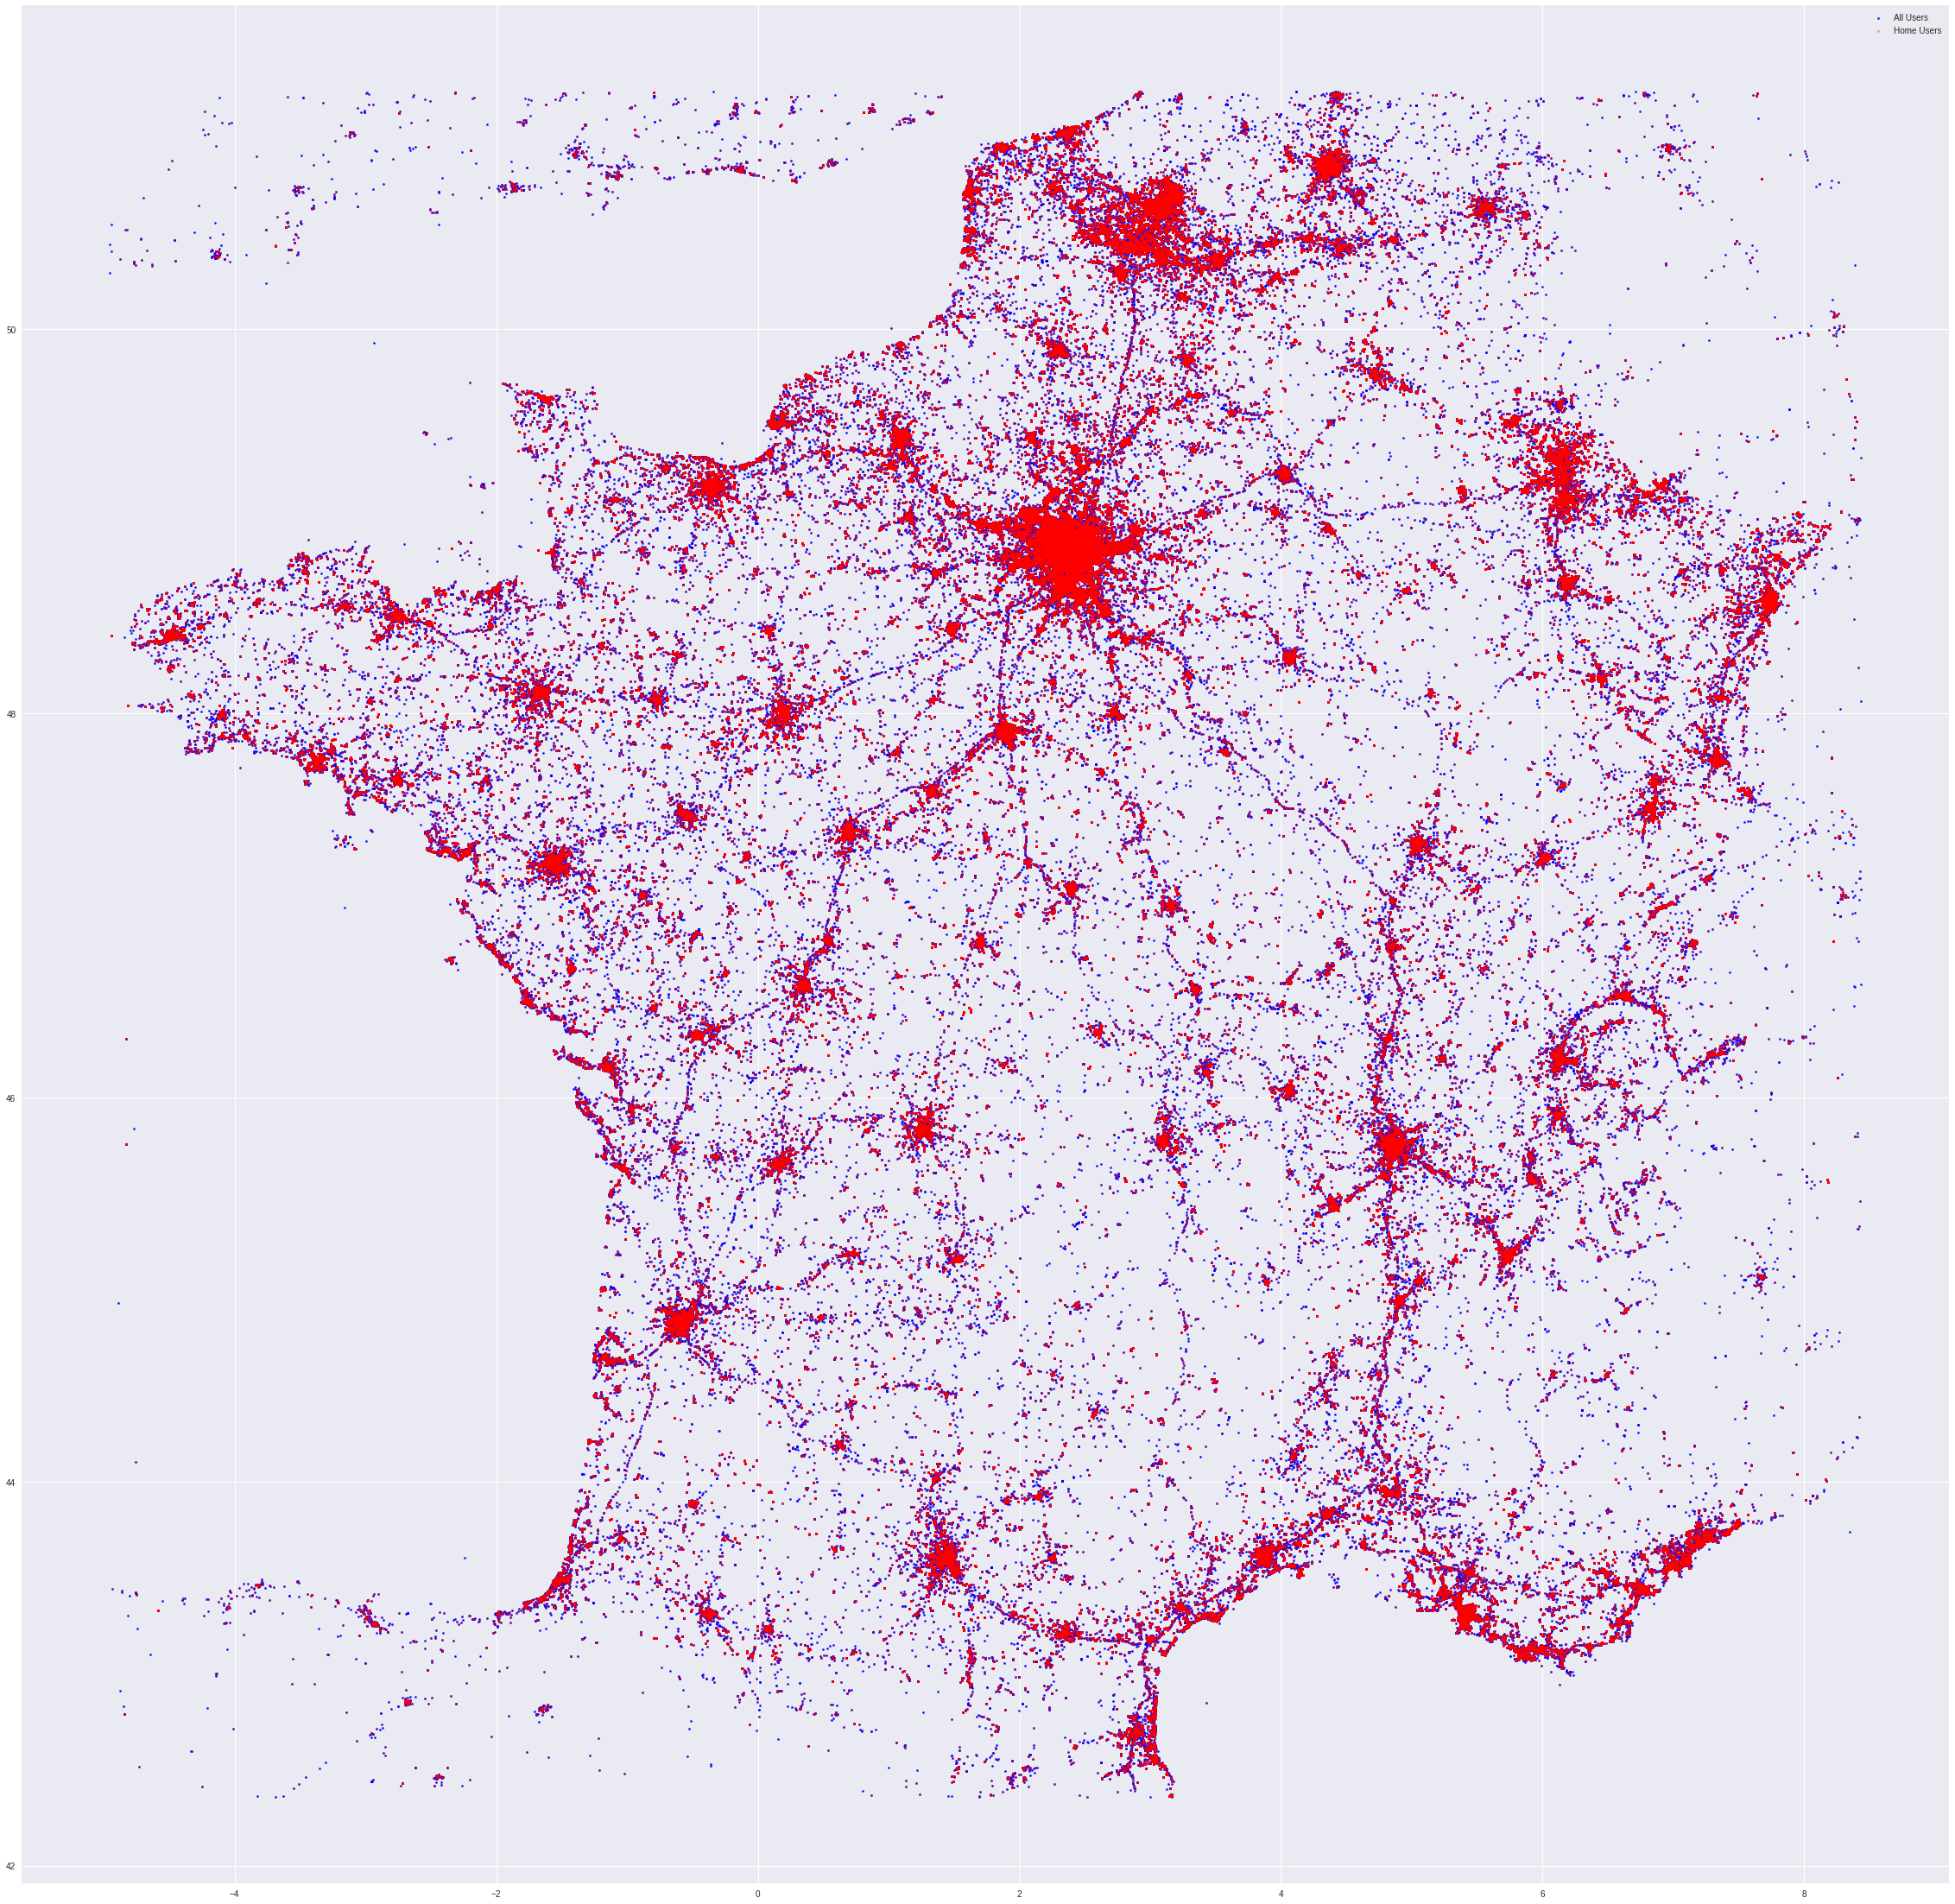

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))
plt.scatter(dgeo_france.lon,dgeo_france.lat,s=5,c='b')
plt.scatter(dgeo_home.lon,dgeo_home.lat,s=5,c='r',alpha=0.4)
plt.legend(["All Users","Home Users"])
plt.show()

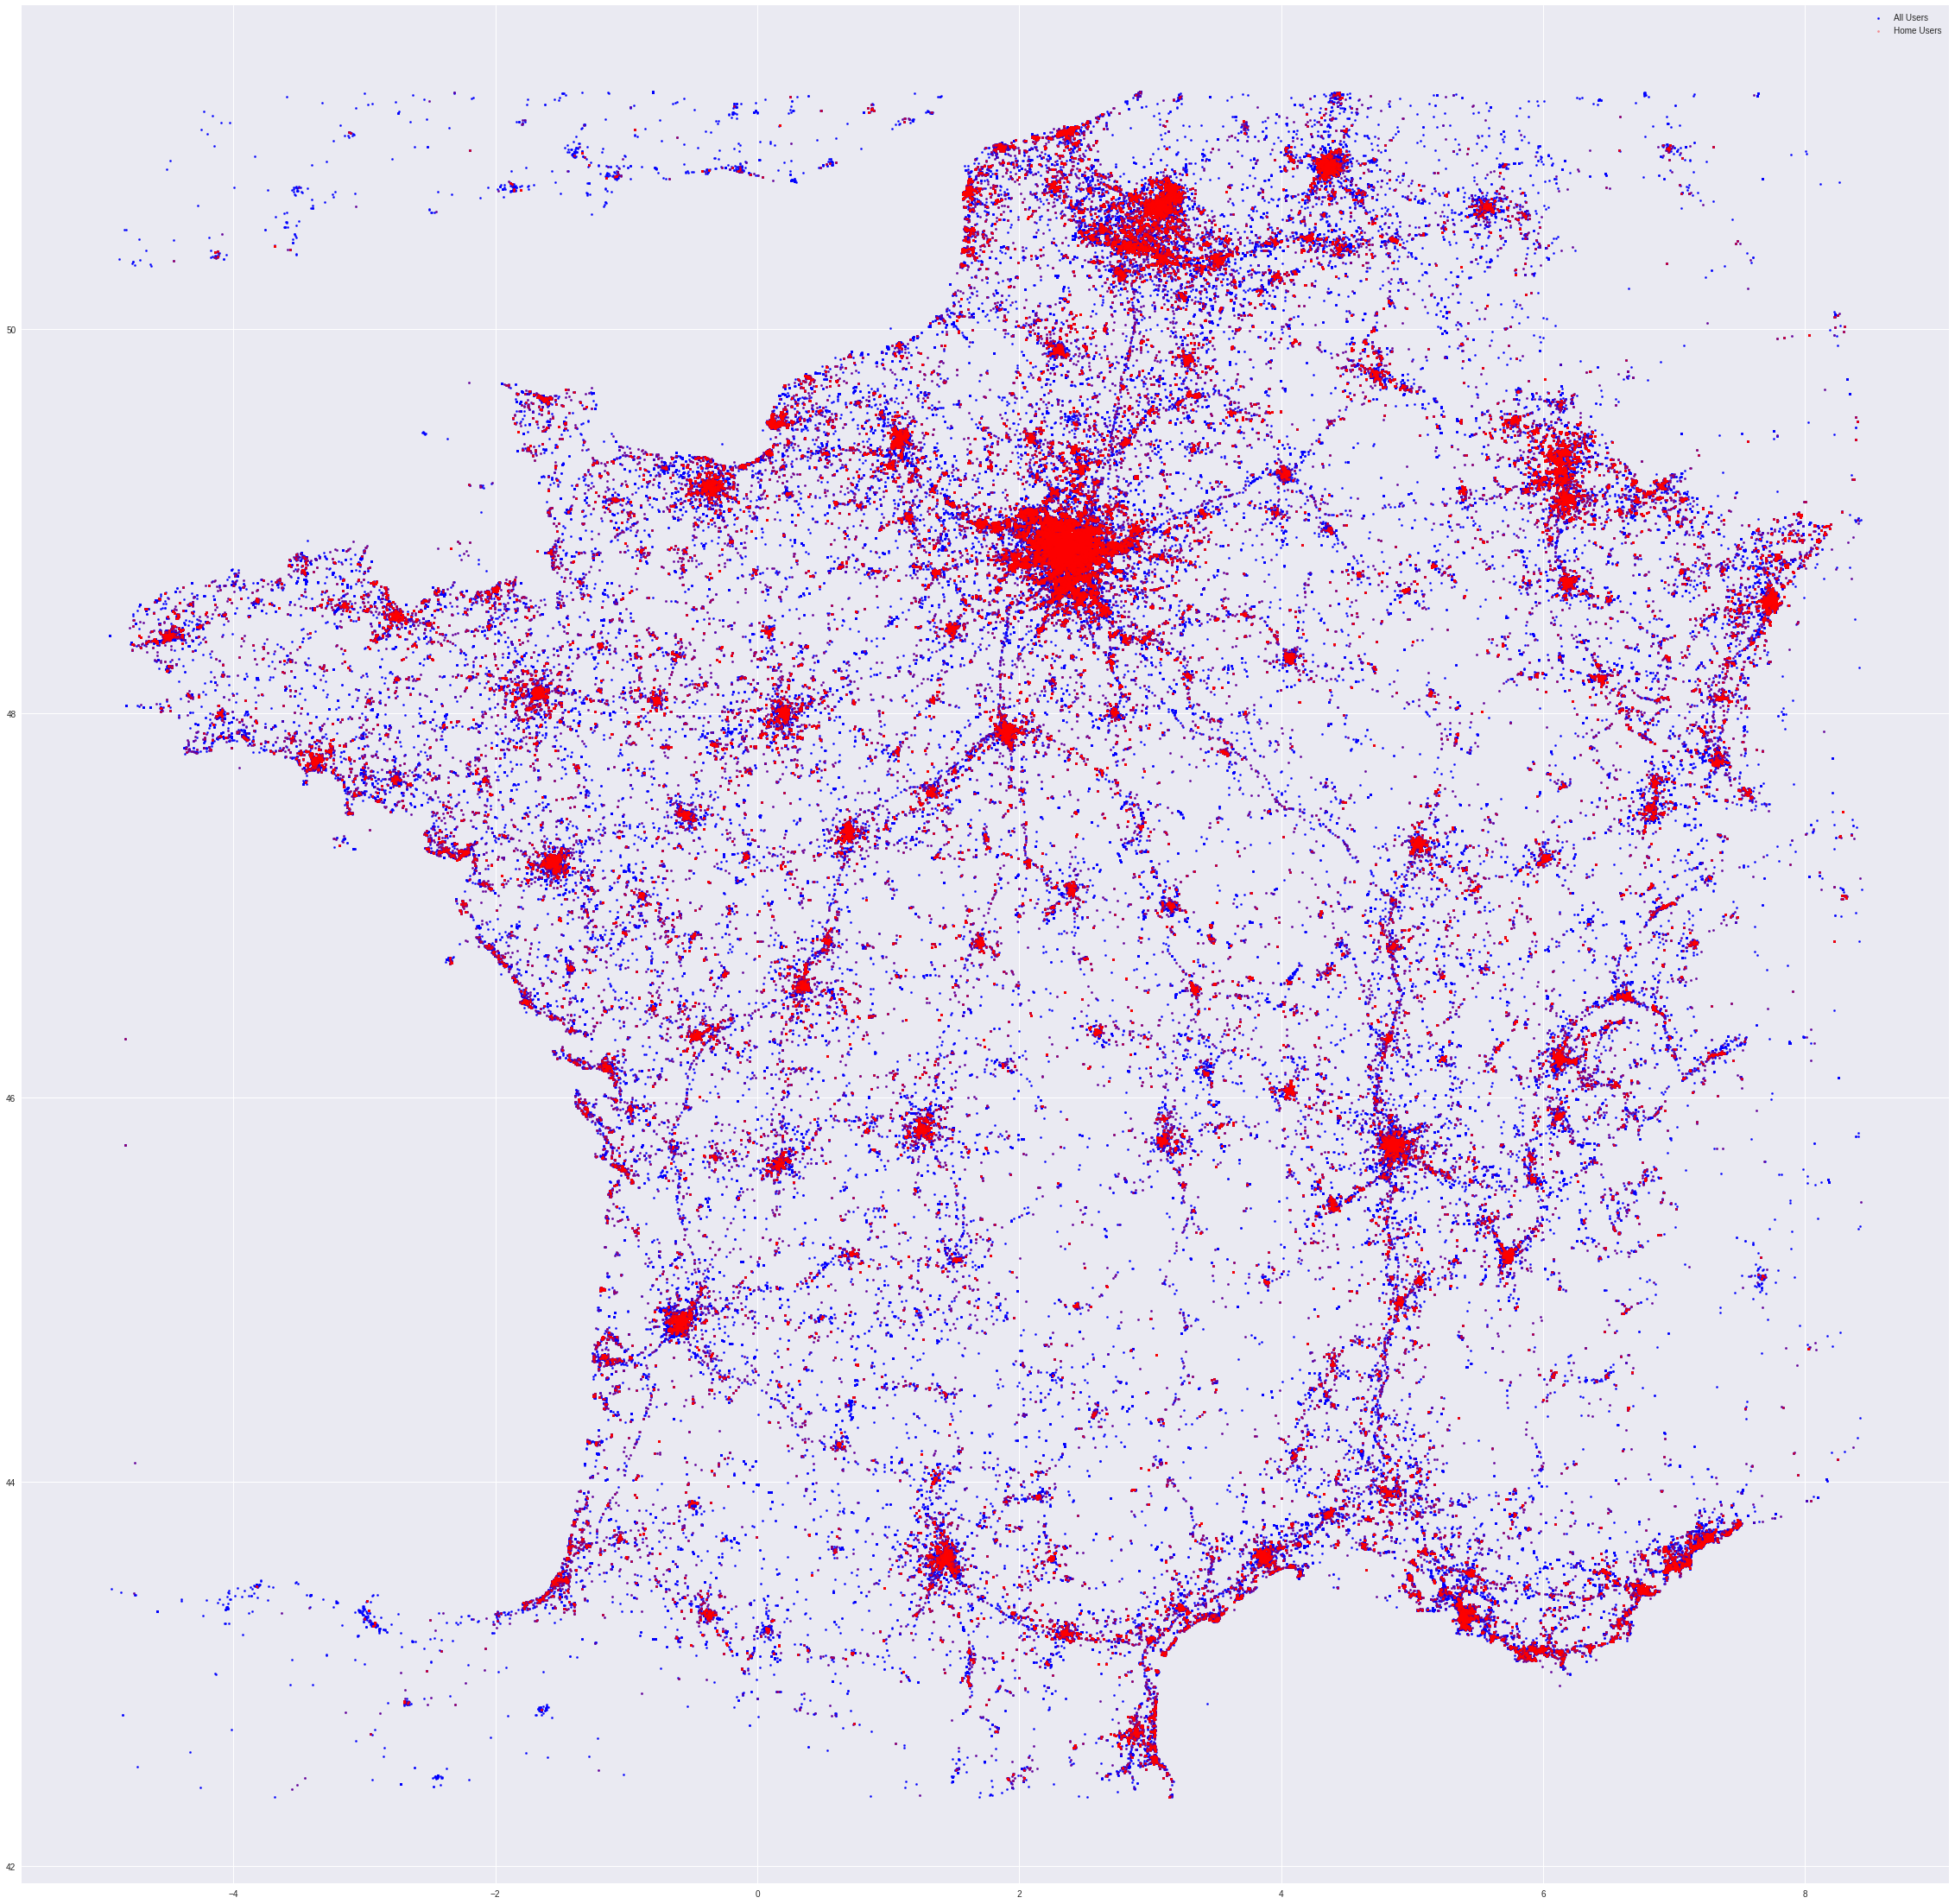

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))
plt.scatter(dgeo_home.lon,dgeo_home.lat,s=5,c='b')
plt.scatter(geo_filter_data_home[:,1],geo_filter_data_home[:,0],s=5,c='r',alpha=0.4)
plt.legend(["All Users","Home Users"])
plt.show()

In [17]:
dic_pd_home={k:pd.DataFrame(v,columns=["lat","lon","day","hour","minu","sec","year","month","fecha"]
               ) for k,v in tqdm(new_dic_real_home.items())}

100%|██████████| 29677/29677 [01:57<00:00, 251.99it/s]


In [18]:
prec_100m=3
from geopy.distance import vincenty

dist_avg=[]
dist_med=[]
fraction_of_locs_in_mode=[]
for usr,pds in tqdm(dic_pd_home.items()):
    points = np.array(pds[["lon","lat"]]).astype(float).tolist()
    points_round_100=[(round(x[0],prec_100m),round(x[1],prec_100m)) for x in points]
    weight_locs=Counter(points_round_100)
    locs=sorted(weight_locs, key=weight_locs.get, reverse=True)
    proj_locs = proj_arr(locs, uk)
    #distance
    N=len(weight_locs)
    dists=np.array([(vincenty(locs[0],loc).meters,weight_locs[loc]) for loc in locs])
    #stats
    dist_avg.append(np.average(dists[:,0],weights=dists[:,1]))
    dist_med.append(np.median([dist[0] for dist in dists for i in range(int(dist[1]))]))
    fraction_of_locs_in_mode.append((weight_locs[locs[0]]+0.0)/sum(weight_locs.values()))    

100%|██████████| 29677/29677 [01:46<00:00, 279.76it/s]


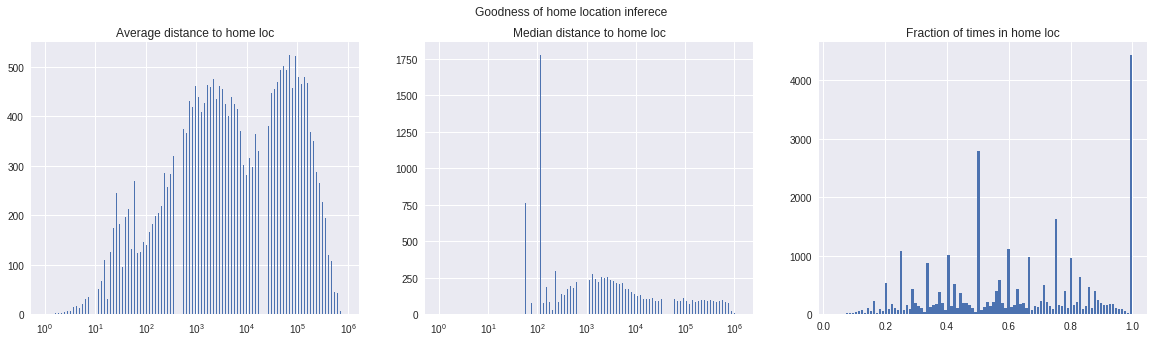

In [19]:
plt.figure(figsize=(20,5))
nb=100
plt.tight_layout() 
plt.suptitle('Goodness of home location inferece')
plt.subplot(131)
bins_avg=[0]+np.logspace(start=0,stop=np.log10(max(dist_avg)),num=nb)
plt.hist(dist_avg,bins=bins_avg,histtype='bar', rwidth=0.3)
plt.xscale('log')
plt.title('Average distance to home loc')
plt.subplot(132)
bins_med=[0]+np.logspace(start=0,stop=np.log10(max(dist_med)),num=nb)
plt.hist(dist_med,bins=bins_med,histtype='bar', rwidth=0.3)
plt.title('Median distance to home loc')
plt.xscale('log')
plt.subplot(133)
plt.hist(fraction_of_locs_in_mode,bins=nb,histtype='bar', rwidth=0.8)
plt.title('Fraction of times in home loc')
plt.show()

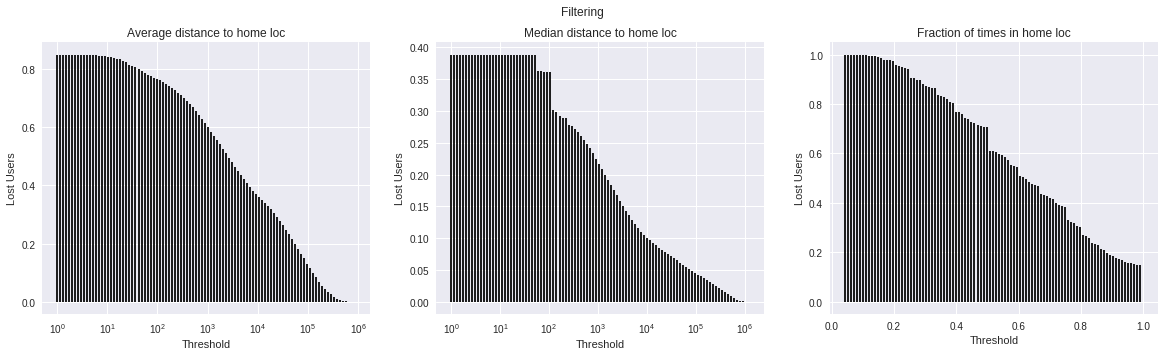

In [20]:
def users_lost_lin(var,nb_points=100):
    var=np.array(var)
    thresh_value=np.linspace(start=min(var)+0.01,stop=max(var),num=nb_points)
    frac_lost=[((var[var>thresh]).shape[0]+0.0)/var.shape[0] for thresh in thresh_value]
    return(thresh_value,frac_lost)
def users_lost_log(var,nb_points=100):
    var=np.array(var)
    thresh_value=[0]+np.logspace(start=0,stop=np.log10(max(var)),num=nb)
    frac_lost=[((var[var>thresh]).shape[0]+0.0)/var.shape[0] for thresh in thresh_value]
    return(thresh_value,frac_lost)


plt.figure(figsize=(20,5))
plt.tight_layout() 
plt.suptitle('Filtering')
plt.subplot(131)
x,y=users_lost_log(dist_avg)
plt.vlines(x, [0], y)
plt.xscale('log')
plt.title('Average distance to home loc')
plt.xlabel("Threshold")
plt.ylabel("Lost Users")
plt.subplot(132)
x,y=users_lost_log(dist_med)
plt.vlines(x, [0], y)
plt.xscale('log')
plt.title('Median distance to home loc')
plt.xlabel("Threshold")
plt.ylabel("Lost Users")
plt.subplot(133)
x,y=users_lost_lin(fraction_of_locs_in_mode)
plt.vlines(x, [0], y)
plt.title('Fraction of times in home loc')
plt.xlabel("Threshold")
plt.ylabel("Lost Users")
plt.show()


In [21]:
usrs=list(dic_pd_home.keys())
med_dist_filter=500
avg_dist_filter=1e3
frac_filter=0.51
ids_filtered=[usr for it,usr in enumerate(usrs)
              if (dist_med[it]< med_dist_filter and
              fraction_of_locs_in_mode[it]>frac_filter and 
              dist_avg[it]<avg_dist_filter)  
             ]
dic_pd_home_filter_the_filter={usr:dic_pd_home[usr] for usr in tqdm(ids_filtered)}
new_dic_real_home_filter_the_filter={usr:new_dic_real_home[usr] for usr in tqdm(ids_filtered)}

100%|██████████| 10348/10348 [00:00<00:00, 425416.15it/s]


# Income Association

## Overall Income Distribution

In [6]:
import pandas as pd
from tqdm import tqdm
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
df_insee=pd.read_csv('/datastore/complexnet/jlevyabi/geoloc/final.csv')
import re;pat = re.compile(r'''(-*\d+\.\d+ -*\d+\.\d+);*''');new_geo=[]
for geo in tqdm(df_insee.geometry_y):
    matches = pat.findall(geo)
    if matches:
        lst = Polygon([tuple(map(float, m.split())) for m in matches])
    else:
        lst=None
    new_geo.append(lst)
df_insee.geometry_y=new_geo
#Create soc_econ dictionary
dic_soc_info={}
for ind,row in tqdm(df_insee.iterrows()):
    geo=row.geometry_yz
    geo_spa_center=(str(round(geo.centroid.y,prec_100m)),str(round(geo.centroid.x,prec_100m)))
    dic_soc_info[geo_spa_center]=row

In [23]:
income_france_pre_filter=np.array([dic_soc_info[(str(round(lat,prec_100m)),str(round(lon,prec_100m)))]['income']
                          for lat,lon in (dgeo_france[["lat","lon"]].values)
                         if (str(round(lat,prec_100m)),str(round(lon,prec_100m))) in dic_soc_info.keys()])
income_france_filter=np.array([dic_soc_info[(str(round(lat,prec_100m)),str(round(lon,prec_100m)))]['income']
                          for lat,lon in geo_filter_data_france
                     if (str(round(lat,prec_100m)),str(round(lon,prec_100m))) in dic_soc_info.keys()])
income_home_pre_filter=np.array([dic_soc_info[(str(round(lat,prec_100m)),str(round(lon,prec_100m)))]['income']
                          for lat,lon in dgeo_home[["lat","lon"]].values
                       if (str(round(lat,prec_100m)),str(round(lon,prec_100m))) in dic_soc_info.keys()])
income_home_filter=np.array([dic_soc_info[(str(round(lat,prec_100m)),str(round(lon,prec_100m)))]['income']
                          for lat,lon in geo_filter_data_home
                   if (str(round(lat,prec_100m)),str(round(lon,prec_100m))) in dic_soc_info.keys()])

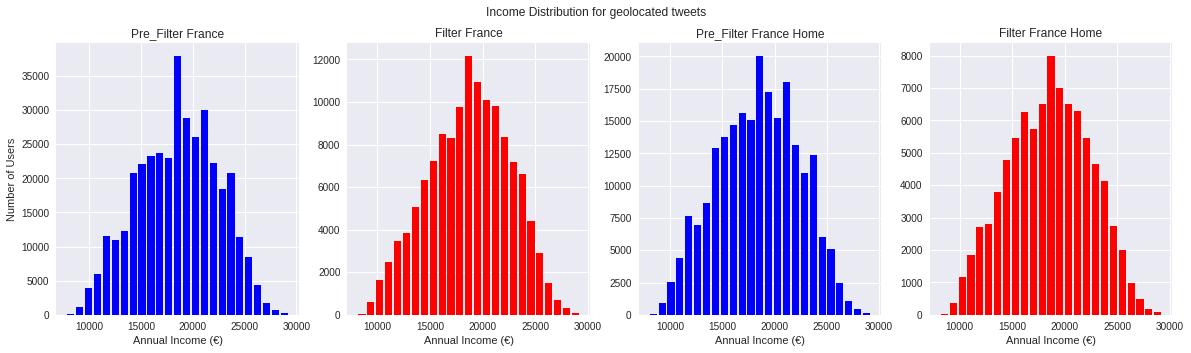

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
nb=25
plt.tight_layout() 
plt.suptitle('Income Distribution for geolocated tweets')
plt.subplot(141)
plt.hist(income_france_pre_filter[~(np.isnan(income_france_pre_filter))],bins=nb,histtype='bar', rwidth=0.8,color="blue")
plt.title('Pre_Filter France')
plt.xlabel('Annual Income (€)')
plt.ylabel('Number of Users')
plt.subplot(142)
plt.hist(income_france_filter[~(np.isnan(income_france_filter))],bins=nb,histtype='bar', rwidth=0.8,color="red")
plt.title('Filter France')
plt.xlabel('Annual Income (€)')
plt.subplot(143)
plt.hist(income_home_pre_filter[~(np.isnan(income_home_pre_filter))],bins=nb,histtype='bar', rwidth=0.8,color="blue")
plt.title('Pre_Filter France Home')
plt.xlabel('Annual Income (€)')
plt.subplot(144)
plt.hist(income_home_filter[~(np.isnan(income_home_filter))],bins=nb,histtype='bar', rwidth=0.8,color="red")
plt.title('Filter France Home')
plt.xlabel('Annual Income (€)')
plt.show()

## User Income Assignment 

In [25]:
def moded_location_to_income(dic_usr_locs,dic_soc_info,precision):
    new_dic_usr_loc={}
    for k,v in tqdm(dic_usr_locs.items()):
        usr_info=np.array(v)[:,:2].astype(float).tolist()
        locs=[((round(lat,precision)),(round(lon,precision))) 
              for lat,lon in usr_info if (str(round(lat,precision)),str(round(lon,precision))) in dic_soc_info.keys()]
        if len(locs)==0:
            continue
        count_locs=Counter(locs)
        most_common=count_locs.most_common(1)[0]
        lat,lon=most_common[0]
        new_dic_usr_loc[k]=(most_common[0],dic_soc_info[(str(round(lat,precision)),str(round(lon,precision)))]['income'],
                            most_common[1]/sum(np.array(list(count_locs.values()))+0.0))
    return new_dic_usr_loc

def location_to_weighted_income(dic_usr_locs,dic_dist,dic_soc_info,precision):
    new_dic_usr_loc={}
    for k,v in tqdm(dic_usr_locs.items()):
        usr_info=np.array(v)[:,:2].astype(float).tolist()
        locs=[((round(lat,precision)),(round(lon,precision))) 
              for lat,lon in usr_info if (str(round(lat,precision)),str(round(lon,precision))) in dic_soc_info.keys()]
        if len(locs)==0:
            continue
        count_locs=Counter(locs)
        most_common=count_locs.most_common(1)[0]
        most_common_count=most_common[1]
        incomes=[dic_soc_info[(str(round(lat,precision)),str(round(lon,precision)))]['income'] for lat,lon in locs ]
        insert=None
        if k in dic_dist.keys():
            insert=dic_dist[k]
        new_dic_usr_loc[k]=(np.mean(incomes),np.std(incomes),insert)
    return new_dic_usr_loc

### Second Layer Filter(10K users)

In [ ]:
new_dic_real_home_filter_the_filter[list(new_dic_real_home_filter_the_filter.keys())[0]]

In [35]:
dic_income_avg_home_filter_the_filter=location_to_weighted_income(new_dic_real_home_filter_the_filter,
                                                                 dic_dist_home,dic_soc_info,prec_100m)
dic_income_moded_home_filter_the_filter=moded_location_to_income(new_dic_real_home_filter_the_filter,
                                                                 dic_soc_info,prec_100m)

100%|██████████| 10348/10348 [00:07<00:00, 1471.11it/s]


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.hist([v[0] for v in dic_income_moded_home_filter_the_filter.values()
          if not np.isnan(v[1])],bins=nb,histtype='bar', rwidth=0.8)
plt.xlabel('Annual Income (€)')
plt.ylabel('Number of Users')
plt.title('Filter the filter home Mode')

plt.subplot(122)
plt.hist([v[1] for v in dic_income_avg_home_filter_the_filter.values()
          if not np.isnan(v[1])],bins=nb,histtype='bar', rwidth=0.8)
plt.xlabel('Annual Income (€)')
plt.ylabel('Number of Users')
plt.title('Filter the filter home Avg')
plt.show()

### First Layer filters(30K users)

In [ ]:
dic_income_moded_france=moded_location_to_income(new_dic_real_france,dic_soc_info,prec_100m)
dic_income_weighted_france=location_to_weighted_income(new_dic_real_france,dic_dist_all,dic_soc_info,prec_100m)
dic_income_moded_home=moded_location_to_income(new_dic_real_home,dic_soc_info,prec_100m)
dic_income_weighted_home=location_to_weighted_income(new_dic_real_home,dic_dist_home,dic_soc_info,prec_100m)

pre_filter_dic_income_moded_france=moded_location_to_income(dic_locs_all,dic_soc_info,prec_100m)
pre_filter_dic_income_weighted_france=location_to_weighted_income(dic_locs_all,dic_dist_all,dic_soc_info,prec_100m)
pre_filter_dic_income_moded_home=moded_location_to_income(dic_locs_home,dic_soc_info,prec_100m)
pre_filter_dic_income_weighted_home=location_to_weighted_income(dic_locs_home,dic_dist_home,dic_soc_info,prec_100m)


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
nb=25
plt.tight_layout() 
plt.suptitle('Income Distribution for geolocated users')

plt.subplot(241)
plt.hist([v[1] for v in pre_filter_dic_income_moded_france.values() if not np.isnan(v[1])],bins=nb,histtype='bar', rwidth=0.8)
plt.title('Pre-filter France Mode')
plt.subplot(242)
plt.hist([v[1] for v in pre_filter_dic_income_moded_home.values() if not np.isnan(v[1])],bins=nb,histtype='bar', rwidth=0.8)
plt.title('Pre-filter France (Home) Mode')
plt.subplot(243)
plt.hist([v[0] for v in pre_filter_dic_income_weighted_france.values() if not np.isnan(v[0])],bins=nb,histtype='bar', rwidth=0.8)
plt.title('Pre-filter France Weighted')
plt.subplot(244)
plt.hist([v[0] for v in pre_filter_dic_income_weighted_home.values() if not np.isnan(v[0])],bins=nb,histtype='bar', rwidth=0.8)
plt.title('Pre-filter France (Home) Weighted')

plt.subplot(245)
plt.hist([v[1] for v in dic_income_moded_france.values() if not np.isnan(v[1])],bins=nb,histtype='bar', rwidth=0.8)
plt.title('Filter France Mode')
plt.subplot(246)
plt.hist([v[1] for v in dic_income_moded_home.values() if not np.isnan(v[1])],bins=nb,histtype='bar', rwidth=0.8)
plt.title('Filter France (Home) Mode')
plt.subplot(247)
plt.hist([v[0] for v in dic_income_weighted_france.values() if not np.isnan(v[0])],bins=nb,histtype='bar', rwidth=0.8)
plt.title('Filter France Weighted')
plt.subplot(248)
plt.hist([v[0] for v in dic_income_weighted_home.values() if not np.isnan(v[0])],bins=nb,histtype='bar', rwidth=0.8)
plt.title('Filter France (Home) Weighted')
plt.show()

In [ ]:
import pickle 
d_mob_study_out={
    'dic_income_moded_france':dic_income_moded_france,
    'dic_income_moded_home':dic_income_moded_home,
    'dic_income_weighted_france':dic_income_weighted_france,
    'dic_income_weighted_home':dic_income_weighted_home,
    'pre_filter_dic_income_moded_france':pre_filter_dic_income_moded_france,
    'pre_filter_dic_income_moded_home':pre_filter_dic_income_moded_home,
    'pre_filter_dic_income_weighted_france':pre_filter_dic_income_weighted_france,
    'pre_filter_dic_income_weighted_home':pre_filter_dic_income_weighted_home,
    'new_dic_real_france':new_dic_real_france,
    'new_dic_real_home':new_dic_real_home}

In [1]:
import pickle
pickle.dump(new_dic_real_home_filter_the_filter, open( "new_dic_real_home_max_filtered.p", "wb" ))
new_dic_real_home_filter_the_filter=pickle.load(open( "new_dic_real_home_max_filtered.p", "rb" ))